## Analysing spotify listening history and creating models

### Introduction

Being an avid music listener, I accumulated years and years of my spotify listening history, which is over 500 hours of streaming time. I am always on a lookout for discovering new genres of music and enjoy exploring new music. Now with this substantial amount of data, I felt I could do something with it, and I built classifiers which could generate song recommendations based on their music taste and let them know whether or not a song is a 'favorite'. The recommendations provided by Spotify are no doubt state of the art. With their discover weekly showcasing new undiscovered songs to the user on a weekly basis. But there’s a finite number of songs recommended through that feature. With this project, one can generate recommendations based on their own music taste and their past listening history on a large scale.

### Goal

The goal of this project is to recommend a list of songs based on the listening history and spotify’s audio features and analyze interesting results of your music taste using various classifier models namely Logistic Regression, Random Forest and Decision tree, to discover which songs appeal the most. The metric used for evaluating the results is F1 score because it is best suited when we care more about the false positives and false negatives. All the more, for a heavily imbalanced problem, f1 score is a better metric to choose.

### Data

I used two datasets to proceed further namely, streaminghistorymerged.csv and SpotifyAudioFeaturesApril2019.csv. Now, Spotify does not readily provide your listening data to you in the application. One has to go to their Spotify account website on the internet and put a request to Spotify to send you your user data. You then get an email saying that it might take up to 30 days for Spotify to send that data. But it usually takes around 2-3 days and you receive the data in your email. The data is a zip file with vast information about your spotify data. The zip file contains several JSON files like searchqueries.json, payments.json, yourlibrary.json and other files which contain useful information of your account as well as data of your interaction history with music on Spotify’s application.

The 3 streaming history files were then converted to csv through a python script and then later merged into one file called ‘streamingHostorymerged.csv’. It has 22,706 rows and 4 columns namely artist, date(time when the stream ended), msPlayed(minutes in milliseconds) and trackName. The SpotifyAudioFeaturesApril2019.csv file contains 130,663 rows and 17 columns and they are related to the songs features like acousticness, liveliness, popularity, instrumentalness etc.

#### Why use the features of the song?

The features of a song are quite important here in predicting a user’s music taste. For example, a song which is good for dancing will have a maximum danceability value of 1 and will be a good song to shake a leg. If we want to find a song with a good energy, the energy feature of that song should be 1, indicating that the track is energetic, fast, noisy and loud. Let’s say you like acoustic music a lot more, then one would look for an acousticness value of 1. In the end, the features having a stronger correlation with the favorite songs are used to make the predictions.

### Approach

- Data Cleaning and Exploration
- Using SMOTE for oversampling
- Training and comparing models
- Generating predictions

### Results and Future Scope

In order to select a good classifier, I compared 3 algorithms namely Random Forest Classifier, Logistic Regression Model and Decision Tree Model. The Logistic Regression model performed poorly with just 70% of mean f1-score after using 10-fold cross validation. Both the Random Forest classifier and the Decision Tree model performed great with 99% of mean f1 score. But the Random Forest model was better when numbers to the right of 0.99 were considered. Additionally, the Random Forest model performed better on the unseen test data set with a f1 score of 0.997, while the Decision Tree model had a score of 0.993. There isn’t much difference but if scores were to be considered, Random Forest performed better. Alternatively, one can also use a decision tree model which can yield similar results.

In all, it helped me to generate recommendation of songs at at a massive scale instead of just limiting to a few songs like in Discover Weekly of Spotify. In future, I can automate the process of creating certain playlists by converting the predicted csv files into Spotify playlists which would be more convenient for me.

## Code

### Data Cleaning and Exploration

In [1]:
#importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import os,glob
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
#reading the streaming history csv files

streamhist_0 = pd.read_csv('/Users/yashd/Documents/Spotify project/StreamingHistory0.csv')
streamhist_1 = pd.read_csv('/Users/yashd/Documents/Spotify project/StreamingHistory1.csv')
streamhist_2 = pd.read_csv('/Users/yashd/Documents/Spotify project/StreamingHistory2.csv')

In [3]:
#merging of three streaming history files

path = "/Users/yashd/Documents/Spotify project/"
all_files = glob.glob(os.path.join(path, "StreamingHistory*.csv"))
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged   = pd.concat(df_from_each_file, ignore_index=True)
df_merged.to_csv( "/Users/yashd/Documents/Spotify project/streaminghistorymerged.csv")

In [4]:
streaming_hist=pd.read_csv('/Users/yashd/Documents/Spotify project/streaminghistorymerged.csv')
streaming_hist.shape

(22706, 5)

In [5]:
#reading the spotify features csv file

spotify_features=pd.read_csv('/Users/yashd/Documents/Spotify project/SpotifyAudioFeaturesApril2019.csv')

In [6]:
#renaming certain column names

streaming_hist = streaming_hist.rename(columns={"artistName":"artist","endTime":"date","trackName":"track"})


In [7]:
streaming_hist = streaming_hist.drop('Unnamed: 0', axis=1)

streaming_hist.head()

,date,artist,track,msPlayed
0,2020-12-04 13:12,Zimmz,Fracture,34311
1,2020-12-06 06:21,KK,Ajab Si,18234
2,2020-12-06 06:22,Lucky Ali,Hairat,17659
3,2020-12-06 06:22,Charlie Puth,How Long,43249
4,2020-12-06 06:24,Eric Prydz,NOPUS,15175


In [8]:
spotify_features.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [9]:
spotify_features = spotify_features.rename(columns={"artist_name":"artist","track_name":"track"})

spotify_features.shape

(130663, 17)

We will choose songs with listening count over 12 to be our favorite song

#### Why 12?

When a histogram was plotted grouping the artist and the track together, I could see that frequencies of the song suddenly dropped at after 12 counts, indicating that the songs having a count greater than 12 are the ones which I truly enjoy, and they were not just listened randomly or by chance.

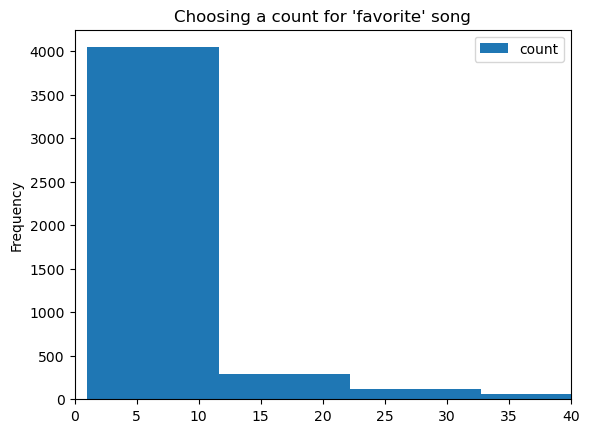

In [10]:
ax = streaming_hist.groupby(['artist','track']).size().to_frame('count').reset_index().plot(kind='hist',bins=10)
ax.set_xlim(0,40)
ax.set_title("Choosing a count for 'favorite' song")
plt.show()

In [11]:
#determining the number of counts of each song and keeping songs with a count > 12

streaming_hist.groupby(['artist','track']).size().to_frame('count').reset_index()
streaming_hist = streaming_hist.groupby(['artist','track']).size().to_frame('count').reset_index()
streaming_hist = streaming_hist[streaming_hist['count']>=12]
# To display the top 5 rows
streaming_hist.head(5)
#streaming_hist.shape

,artist,track,count
2,*NSYNC,I Want You Back - Radio Edit,12
9,21 Savage,a lot,25
18,2Pac,All Eyez On Me (ft. Big Syke),21
23,3LAU,How You Love Me,28
26,5 Seconds of Summer,She Looks So Perfect,12


In [12]:
#matching the track names and artists from streaming history with that of spotify features data, in order to fetch
#the features of the songs

spotify_features['same_artists'] = spotify_features.artist.isin(streaming_hist.artist) 
spotify_features['same_track'] = spotify_features.track.isin(streaming_hist.track) 

In [13]:
spotify_features['same_artists'].value_counts()

False    127480
True       3183
Name: same_artists, dtype: int64

In [14]:
spotify_features['same_track'].value_counts()

False    130042
True        621
Name: same_track, dtype: int64

In [15]:
streaming_hist.shape

(522, 3)

In [16]:
#creating the column 'favorite'

spotify_features["favorite"] = np.where((spotify_features['same_artists'] == True) & (spotify_features['same_track'] == True),1,0)

In [17]:
spotify_features = spotify_features.drop(["same_artists","same_track"], axis=1)


In [61]:
original = spotify_features.copy(deep= True)

In [19]:
#shows the imbalancing of the classes

spotify_features["favorite"].value_counts()

0    130617
1        46
Name: favorite, dtype: int64

### Using SMOTE for oversampling

When I observed the favorite column after all the matching and merging, class ‘1’ was heavily imbalanced with just 46 values since the spotifyfeatures data set is a little old and ‘0’ class with around 13000 values. Hence to balance this out, I used SMOTE to oversample the minority class 1. Also, undersampling the majority class is never an option in this scenario.

In [20]:
#using SMOTE to generate synthetic samples from the minority class

X = spotify_features.drop(columns=['favorite','artist','key','mode','time_signature','track_id','track'])
y = spotify_features.favorite
smt = SMOTE()
X, y = smt.fit_resample(X, y)
X['favorite'] = y
X.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,favorite
0,0.005820,0.743,238373,0.339,0.000,0.0812,-7.678,0.4090,203.927,0.118,15,0
1,0.024400,0.846,214800,0.557,0.000,0.2860,-7.259,0.4570,159.009,0.371,0,0
2,0.025000,0.603,138913,0.723,0.000,0.0824,-5.890,0.0454,114.966,0.382,56,0
3,0.029400,0.800,125381,0.579,0.912,0.0994,-12.118,0.0701,123.003,0.641,0,0
4,0.000035,0.783,124016,0.792,0.878,0.0332,-10.277,0.0661,120.047,0.928,0,0


In [21]:
X['favorite'].value_counts()

0    130617
1    130617
Name: favorite, dtype: int64

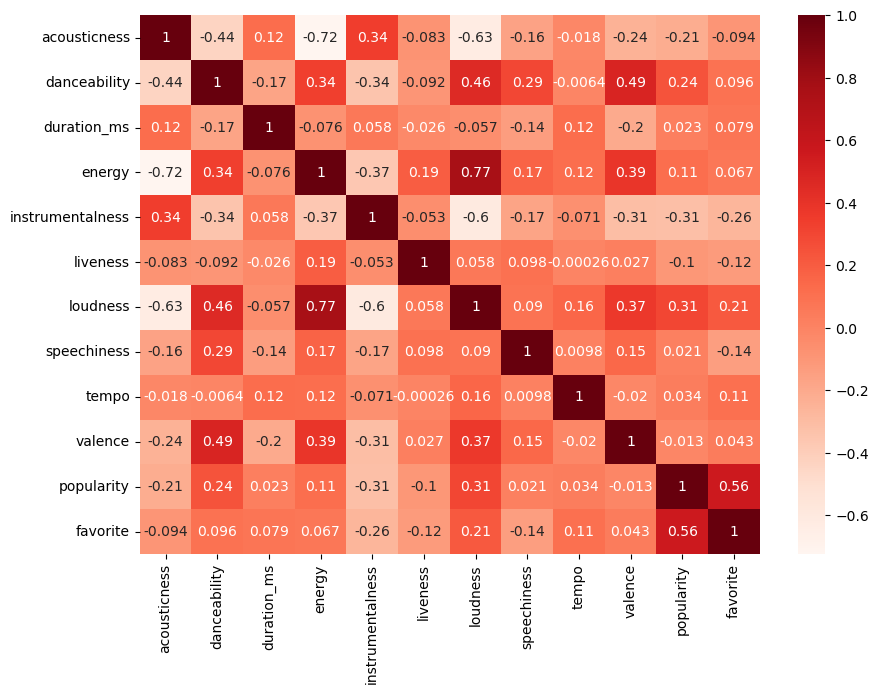

In [22]:
#correaltion matrix

plt.figure(figsize=(10,7))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Looking at the correlation plot, of all the features, **popularity** seems to be highly correlated with **favorite**, followed by **instrumentalness**, **speechiness**, **loudness**, **liveness** and **tempo**, with **loudness**, **popularity** being positively correlated with the response. Nevertheless, I chose all the feature variables for the model. I feel that all the audio features have a hand in determining a favorite song, and features like energy, danceability aren’t too bad because I tend to like energetic songs and songs I can dance to as well. This was verified with using the .describe() function on the values of features where favorite is equal to 1. The mean scores for both energy and danceability were around 0.6, which is good.

### Training and comparing models

In order to select a good classifier, I compared 3 algorithms namely Random Forest Classifier, Logistic Regression Model and Decision Tree Model.

In [23]:
#doing a train-test-split to split the data into training and testing

x_train, x_test, y_train, y_test = train_test_split(X.drop(columns='favorite'), X.favorite,test_size = .25)

For each of the model, I used cross-validation to see how the model performs

In [24]:
#Logistic Regression model

logreg = LogisticRegression()
logreg_sc = cross_val_score(logreg, x_train, y_train, cv=10, scoring="f1")
print(np.mean(logreg_sc))

0.7029067468405951


In [25]:
#Random Forest Classifier 

rf = RandomForestClassifier(n_estimators=20, max_depth=25)
rf_sc= cross_val_score(rf, x_train, y_train, cv=10, scoring="f1")
print(np.mean(rf_sc))

0.9953893993741962


In [26]:
#utilizing hyperparameter optimizaton using gridsearch

param_grid = {
                 'n_estimators': [5, 10, 15, 20,25],
                 'max_depth': [10,15,20,25,30]
             }
grid_rf = GridSearchCV(rf, param_grid, cv=10)
grid_rf.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=25, n_estimators=20),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'n_estimators': [5, 10, 15, 20, 25]})

In [27]:
#to determine the best predictors from the gridsearch

grid_rf. best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=20)

In [28]:
rf2 = RandomForestClassifier(n_estimators=20, max_depth=30)
rf2_sc= cross_val_score(rf, x_train, y_train, cv=10, scoring="f1")
print(np.mean(rf2_sc))

0.9955060926461664


In [29]:
X.shape

(261234, 12)

In [30]:
X.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,favorite
count,261234.000000,261234.000000,2.612340e+05,261234.000000,2.612340e+05,261234.000000,261234.000000,261234.000000,261234.000000,261234.000000,261234.000000,261234.000000
mean,0.313134,0.597597,2.200446e+05,0.584030,1.471732e-01,0.179179,-8.827410,0.098290,122.429870,0.449796,38.188390,0.500000
std,0.313353,0.168271,9.371448e+04,0.220413,2.945275e-01,0.130009,5.358546,0.099111,27.856336,0.237584,25.045393,0.500001
min,0.000000,0.000000,3.203000e+03,0.000000,0.000000e+00,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.056352,0.489482,1.783942e+05,0.456004,8.735311e-07,0.104000,-10.045000,0.038400,100.021000,0.256463,19.000000,0.000000
50%,0.176101,0.620096,2.097110e+05,0.615443,5.928964e-04,0.132929,-7.287663,0.057100,122.655926,0.451371,35.000000,0.500000
75%,0.542980,0.721113,2.469070e+05,0.738605,7.038492e-02,0.216223,-5.632591,0.116966,142.857742,0.629282,58.000000,1.000000
max,0.996000,0.996000,5.610020e+06,1.000000,1.000000e+00,0.999000,1.806000,0.966000,249.983000,1.000000,100.000000,1.000000


In [31]:
#Decision Tree model

dt = DecisionTreeClassifier(max_depth=30)
dt_scores = cross_val_score(dt, x_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

0.9927290829756608

In [34]:
preds_rf= rf2.predict(x_test)

In [33]:
rf2.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=10)

In [35]:
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=30)

In [36]:
preds_dt= dt.predict(x_test)

In [37]:
print(accuracy_score(y_test, preds_rf))

0.997427613345787


In [38]:
print(accuracy_score(y_test, preds_dt))

0.9922675282120381


In [39]:
print(f1_score(y_test, preds_dt))

0.992307809477388


In [40]:
print(f1_score(y_test, preds_rf))

0.9974297778593721


In [41]:
logreg.fit(x_train, y_train)

LogisticRegression()

In [42]:
preds_lr= logreg.predict(x_test)

In [43]:
print(f1_score(y_test, preds_lr))

0.6993264495143993


Based on the F1 scores, the Random Forest Model proved to be the better model among the three.

In [44]:
X[X['favorite']==1].describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,favorite
count,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.0
mean,0.283758,0.613735,227461.806771,0.598873,0.070277,0.163462,-7.680101,0.084557,125.388698,0.459969,52.177504,1.0
std,0.274201,0.141343,47784.109806,0.170159,0.178358,0.071900,3.458289,0.061712,24.996758,0.213454,21.793139,0.0
min,0.000213,0.254000,156800.000000,0.138000,0.000000,0.038300,-22.720000,0.023200,75.046000,0.025600,5.000000,1.0
25%,0.074113,0.512387,199160.000000,0.498334,0.000004,0.110928,-8.756382,0.037868,102.910726,0.280269,32.000000,1.0
50%,0.163526,0.634195,218703.000000,0.624572,0.001222,0.137802,-6.829092,0.059207,125.097422,0.482300,54.000000,1.0
75%,0.462246,0.717647,252105.000000,0.723169,0.036456,0.206912,-5.611317,0.110434,146.358823,0.624058,70.000000,1.0
max,0.989000,0.912000,364233.000000,0.937000,0.962000,0.373000,-2.805000,0.306000,199.178000,0.887000,95.000000,1.0


### Generating predictions

In [48]:
original.columns

Index(['artist', 'track_id', 'track', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'popularity', 'favorite'],
      dtype='object')

In [62]:
predictions = rf2.predict(original.drop(columns=['track','track_id','favorite','artist','key','time_signature','mode']))

In [63]:
original['predictions'] = predictions


In [64]:
#fetching songs which were not considered as favorite originally but are predicted to be

original = original[(original['favorite']==0) & (original['predictions'] == 1)]

In [65]:
original = original.drop(columns=['track_id','key','time_signature','mode'])

In [66]:
original

,artist,track,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,favorite,predictions
51,Dirty Projectors,Blue Bird,0.5200,0.530,229333,0.521,0.02890,0.209,-7.939,0.1520,117.259,0.529,37,0,1
204,Allie X,Focus,0.1980,0.569,227330,0.659,0.00618,0.142,-6.839,0.0830,167.893,0.612,32,0,1
644,Electric Light Orchestra,Loser Gone Wild,0.4260,0.331,327133,0.694,0.00338,0.130,-7.686,0.0361,123.220,0.408,28,0,1
649,Electric Light Orchestra,Stranger,0.4230,0.555,268853,0.655,0.16100,0.123,-7.890,0.0260,109.821,0.655,27,0,1
2075,Middle Kids,Bought It,0.3490,0.588,242213,0.724,0.01410,0.119,-5.741,0.0369,112.028,0.270,36,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130415,Gaullin,Moonlight,0.0529,0.813,173067,0.761,0.01190,0.337,-5.687,0.0850,124.957,0.290,86,0,1
130426,Blood Orange,Runnin’,0.4120,0.626,235489,0.414,0.00137,0.147,-10.631,0.1090,179.992,0.388,52,0,1
130527,River Valley Worship,Adore You,0.5660,0.524,257548,0.412,0.00000,0.130,-8.380,0.0292,127.962,0.299,29,0,1
130588,Dominic Fike,King of Everything,0.7840,0.636,194360,0.474,0.06130,0.113,-8.096,0.0770,167.064,0.571,61,0,1
